In [1]:
%load_ext rpy2.ipython

Protocol used by Albertas to make this data: https://benchling.com/anavickas/f/lib_VNejBHt6-protocols/prt_2Bkfh557-meripseq/edit

HIV-1 IIIB Virus


https://aidsreagent.org/reagentdetail.cfm?t=viruses&id=607

We are starting from `fastq` files as raw data: 

## Trimming 

In [ ]:
%%bash 
cd ~/People/Judd/fastq
for f in *_L002_R1_001.fastq.gz; do  
    out=${f/\_S[1-9]*/.trim.fastq.gz}; 
    cutadapt -j 12 -q 15 -m 20 -a NNNAGATCGGAAGAGCACACGTCTGAACTCCAGTCA -o ../trim/$out $f; 
done

## Alignment

Unmmaped reads for each `fastq` file saved for later alignment to HIV genome 

Human genome: `gencode.v28.annotation.gtf`

In [ ]:
%%bash 
STAR --genomeLoad LoadAndExit --genomeDir /rumi/shams/abe/genomes/hg38/
for f in trim/*.fastq.gz;do
    out=${f/.trim.fastq.gz/_};
    out=${out/trim/bam};
    STAR --outSAMtype BAM SortedByCoordinate --readFilesCommand zcat --runThreadN 16 --genomeDir /rumi/shams/abe/genomes/hg38/ --readFilesIn $f --outFileNamePrefix $out --outReadsUnmapped Fastx;
done
STAR --genomeLoad Remove --genomeDir /rumi/shams/abe/genomes/hg38/

All `bam`  files (mapped to human genome or hiv genome) renamed in this format: 
> `<sample>.<species>.<treatment>.<input/m6A>.bam`

### Id transfer 
Read gene names from `gtf` file

In [16]:
import pandas as pd 
import os
import feather as ft


def gtf_id_transfer(gtf):
    # awk code to extract gene ID and Name 
    gtf_raw = os.popen("cat " + gtf + " | awk 'BEGIN{FS=\"\t\"}\
                       {split($9,a,\";\"); if($3~\"gene\") print a[1]\"\t\"a[3]}' | sed 's/gene_id \"//' | sed 's/gene_name \"//' | sed 's/\"//g' | sed 's/ //g'").read().split('\n')
    # data frame 
    gtf_df = pd.DataFrame(
        # col: Names 
        data=[i.split('\t') for i in gtf_raw[:len(gtf_raw)-1]],
#         # index: ids 
#         index=[i.split('\t')[0] for i in gtf_raw[:len(gtf_raw)-1]],
        columns=['ID','Name'], dtype=str)
    return gtf_df

gtf = '/rumi/shams/genomes/hg38/gencode.v28.annotation.gtf'
gtf_df = gtf_id_transfer(gtf)

# pass data between R and Python using feather-format
ft.write_dataframe(gtf_df, 'gtf_df.ft')

In [ ]:
%%R 
library(feather)
gtf_df = read_feather('gtf_df.ft') %>% remove_rownames %>% column_to_rownames(var="ID")

# Peakcalling 

## Control

We used different conda `environment` for exomepeak (and it takes long time to run!!). 

In [ ]:
%%R 
library(exomePeak)
txdb <- makeTxDbFromGFF('/rumi/shams/genomes/hg38/gencode.v28.annotation.gtf',organism='Homo sapiens')
setwd("/rumi/shams/abe/People/Judd/bam")
print (txdb)
res <- exomepeak(
    TXDB=txdb,
    IP_BAM=list.files(pattern='human.NT.m6A.bam$'),
    INPUT_BAM=list.files(pattern='human.NT.input.bam$'),
    OUTPUT_DIR='../exomepeak',
    EXPERIMENT_NAME='control'
)
saveRDS(res, paste('../exomepeak','control', 'results.rds', sep='/'))

### Plot _Guitar_ 
Now, let's draw metagene plots for control samples:
(using seprate env: `Guitar`)

In [7]:
%reload_ext rpy2.ipython

In [6]:
%%R
library(Guitar)

In [4]:
%%R
txdb <- makeTxDbFromGFF('/rumi/shams/genomes/hg38/gencode.v28.annotation.gtf',organism='Homo sapiens')

R[write to console]: Import genomic features from the file as a GRanges object ... 
R[write to console]: OK

R[write to console]: Prepare the 'metadata' data frame ... 
R[write to console]: OK

R[write to console]: Make the TxDb object ... 
R[write to console]: OK



In [5]:
%%R
GuitarPlot(txTxdb = txdb,stBedFiles = list("exomepeak/control/peak.bed"),miscOutFilePrefix = "control")

[1] "20200325183907"
[1] "There are 203835 transcripts of 58381 genes in the genome."
[1] "total 203835 transcripts extracted ..."
[1] "total 94682 transcripts left after ambiguity filter ..."
[1] "total 94682 transcripts left after check chromosome validity ..."
[1] "total 11625 mRNAs left after component length filter ..."
[1] "total 56222 ncRNAs left after ncRNA length filter ..."
[1] "generate components for all tx"
[1] "generate components for mRNA"
[1] "generate components for lncRNA"
[1] "generate chiped transcriptome"
[1] "generate coverage checking ranges for tx"
[1] "generate coverage checking ranges for mrna"
[1] "generate coverage checking ranges for ncrna"
[1] "20200325184342"
[1] "import BED file exomepeak/control/peak.bed"
[1] "sample 10 points for Group1"
[1] "start figure plotting for tx ..."
[1] "start figure plotting for mrna ..."
[1] "start figure plotting for ncrna ..."


In [ ]:
# !magick -density 300 plots/control_mrna_test.pdf -flatten -quality 90 plots/control_mrna_test.png

### Motif analysis 

In [ ]:
%%bash 
cd ~/People/Judd/exomepeak/control/
bedtools getfasta -name -s -fi /rumi/shams/genomes/hg38/hg38.fa -bed peak.bed -split -fo peak.fa
# prepare fasta file for FIRE
perl /flash/hani/bin/Tools/prep_seqs_for_teiser_run.pl peak.fa peaks
# run FIRE --doskipdiscovery=1
perl $FIREDIR/fire.pl --expfile=peaks_teiser.txt --exptype=discrete --fastafile_rna=peaks_teiser.fa --nodups=1 --dodna=0 --dodnarna=0 --species=human --doskipdiscovery=1 --motiffile_rna=motifs_of_interest.txt --oribiasonly=0
mv peaks_teiser.txt_FIRE/ motifs_of_interest_FIRE
# run FIRE --doskipdiscovery=0
perl $FIREDIR/fire.pl --expfile=peaks_teiser.txt --exptype=discrete --fastafile_rna=peaks_teiser.fa --nodups=1 --dodna=0 --dodnarna=0 --species=human --oribiasonly=0

In [189]:
ls ~/People/Judd/exomepeak/control/*FIRE/*/*pdf

/rumi/shams/abe/People/Judd/exomepeak/control/motifs_of_interest_FIRE/RNA/peaks_teiser.txt.densities.pdf
/rumi/shams/abe/People/Judd/exomepeak/control/motifs_of_interest_FIRE/RNA/peaks_teiser.txt.fullmimatrix.pdf
/rumi/shams/abe/People/Judd/exomepeak/control/motifs_of_interest_FIRE/RNA/peaks_teiser.txt.summary.pdf
/rumi/shams/abe/People/Judd/exomepeak/control/peaks_teiser.txt_FIRE/RNA/peaks_teiser.txt.densities.pdf
/rumi/shams/abe/People/Judd/exomepeak/control/peaks_teiser.txt_FIRE/RNA/peaks_teiser.txt.fullmimatrix.pdf
/rumi/shams/abe/People/Judd/exomepeak/control/peaks_teiser.txt_FIRE/RNA/peaks_teiser.txt.summary.pdf


In [204]:
%%bash 
cd ~/People/Judd/
echo '### motifs_of_interest'
for f in exomepeak/control/motifs_of_interest_FIRE/*/*pdf; do 
    base=`basename $f`
    base=${base/peaks_teiser.txt./}
    base=${base/.pdf/}
#     magick -density 300 $f -flatten -quality 90 plots/fire.motifs_of_interest.$base.png
    echo '<img src="plots/fire.motifs_of_interest.'$base'.png" title="'$base'" style="height:600px">'
done 

echo '### discovery_mode'
for f in exomepeak/control/peaks_teiser.txt_FIRE/*/*pdf; do 
    base=`basename $f`
    base=${base/peaks_teiser.txt./}
    base=${base/.pdf/}
#     magick -density 300 $f -flatten -quality 90 plots/fire.discovery_mode.$base.png
    echo '<img src="plots/fire.discovery_mode.'$base'.png" title="'$base'" style="height:600px">'
done 

### motifs_of_interest
<img src="plots/fire.motifs_of_interest.densities.png" title="densities" style="height:600px">
<img src="plots/fire.motifs_of_interest.fullmimatrix.png" title="fullmimatrix" style="height:600px">
<img src="plots/fire.motifs_of_interest.summary.png" title="summary" style="height:600px">
### discovery_mode
<img src="plots/fire.discovery_mode.densities.png" title="densities" style="height:600px">
<img src="plots/fire.discovery_mode.fullmimatrix.png" title="fullmimatrix" style="height:600px">
<img src="plots/fire.discovery_mode.summary.png" title="summary" style="height:600px">


# Running a custom pipeline 

Here we're using https://github.com/gold-lab/bed12ToGTF to make gtf file from control exomepeak result.

https://metacpan.org/pod/Bio::FeatureIO::gtf

In [243]:
%%bash
cat exomepeak/control/peak.bed | sort -k4 | \
# rename features peak by peak
awk -F "\t" '{OFS=FS}NR>1{$4=$4"_peak"}; cnt[$4]++{$4=$4"_"cnt[$4]} 1' | \
# bed12 to gtf
perl ../../Workflows/bed12ToGTF/bed12ToGTF.1.pl | \
awk '{gsub(/\"|\;/,"")}1''{gsub(/transcript_id/,"gene_id")}1''{gsub(/ exon_number [[:digit:]]/,"")}1' > exomepeak/control/peak.gtf

Using `featureCounts` to count reads which are present in control peak cordinates (found by `exomepeak`). 

In [244]:
%%bash
declare -a StringArray=('METTL14' 'METTL3' 'Virma' 'WTAP')
for enz in "${StringArray[@]}"; 
    do for f in bam/*human.$enz*.bam; 
        do out=${f/.bam/.fc}; out=${out/bam/peakcount}; 
            featureCounts -T 12 -O -t exon -g gene_id -a exomepeak/control/peak.gtf -o $out $f; 
    done;
done


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v1.6.0

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 1 BAM file                                       ||
||                           S bam/s23.human.METTL14.input.bam                ||
||                                                                            ||
||             Output file : peakcount/s23.human.METTL14.input.fc             ||
||                 Summary : peakcount/s23.human.METTL14.input.fc

In [10]:
%%bash 
for f in bam/*human.NT*.bam; do 
    out=${f/.bam/.fc}; out=${out/bam/peakcount}; 
    featureCounts -T 12 -O -t exon -g gene_id -a exomepeak/control/peak.gtf -o $out $f; 
done


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v1.6.0

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 1 BAM file                                       ||
||                           S bam/s23.human.NT.input.bam                     ||
||                                                                            ||
||             Output file : peakcount/s23.human.NT.input.fc                  ||
||                 Summary : peakcount/s23.human.NT.input.fc.summ

## Differential methylation

In [4]:
%reload_ext rpy2.ipython

In [6]:
%%R 
library(DESeq2)
library(tidyverse)
library(ggplot2)
require(ggrepel)
library(patchwork)
library(feather)
gtf_df = read_feather('gtf_df.ft') %>% remove_rownames %>% column_to_rownames(var="ID")

pca = list(); vol = list(); hist = list()

using `DESeq2` to find differential methylation peaks: 

### Contrast design: $\frac{m6A^{treated}}{input^{treated}}$ vs.$\frac{m6A^{nontreated}}{input^{nontreated}}$

In [21]:
%%R
all_dds = list()
all_res = list()
for (treat in c('METTL14','METTL3','Virma','WTAP'
               )){
    treat.input <- list.files(path = 'peakcount',pattern=paste('human.',treat,".input.fc$",sep = ''))
    treat.m6A <- list.files(path = 'peakcount',pattern=paste('human.',treat,".m6A.fc$",sep = ''))
    
    n_treat.input <- list.files(path = 'peakcount',pattern=paste("human.NT.input.fc$",sep = ''))
    n_treat.m6A <- list.files(path = 'peakcount',pattern=paste("human.NT.m6A.fc$",sep = ''))
    
    files = c(treat.input, treat.m6A, n_treat.input, n_treat.m6A)
    # meta
    reps <- rep(c('s23','s24'),2)
    ip <- c(rep('input',2),rep('m6A',2))
    conds <- c(paste(treat,ip, sep='.'), paste('NT',ip, sep='.'))
    all_conds <- c(paste(reps,treat,ip, sep='.'), paste(reps,'NT',ip, sep='.'))
    datalist <- lapply(files, function(x){read.table(file=paste('peakcount/', x, sep = ""),skip=1,sep='\t',header=TRUE,colClasses=c(NA, "NULL", "NULL", "NULL", "NULL", "NULL", NA),check.names=F)})
    m <- Reduce(function(...) merge(..., by=1, all = TRUE), datalist)
    rownames(m) <- m[,1]
    m <- m[,-1]
    m[is.na(m)]<-0
    m <- round(m)
    colnames(m) <- all_conds
    colData <- data.frame(cond = conds, rep = reps, row.names=all_conds)
    dds <- DESeqDataSetFromMatrix(countData = m, colData = colData, design = ~ cond + rep)
    dds$cond <- relevel(dds$cond, ref="NT.input")
    dds <- DESeq(dds)
    all_dds[[treat]] = dds
    # normalized counts 
    ncu <- counts(dds, normalized=TRUE)
    # contrast design: (treat_m6A - treat_input) - (NT_m6A - NT_input)
    res <- results(dds, 
                   contrast=list(
                       c(paste("cond_",treat,".m6A_vs_NT.input",sep="")), 
                       c(paste("cond_",treat,".input_vs_NT.input",sep=""),
                         "cond_NT.m6A_vs_NT.input")), 
                   listValues=c(1,-1))    
    # idtransfer
    res <- as.data.frame(res)
    peak_ids = strsplit(rownames(m), '_',)
    ids = unlist(lapply(peak_ids, '[[', 1))
    res$name = gtf_df[ids,]
    
    all_res[[treat]] = res
    # save files 
    write.table(res, paste('deseq/d_mtyl_',treat,'_vs_NT.txt',sep=''), sep="\t", quote=FALSE, col.names=NA)
    # Raw tabels 
    write.table(ncu, file=paste('deseq/d_mtyl_',treat,'_peak_count_table_DE2norm.txt',sep=''), sep="\t", quote=FALSE, col.names=all_conds) 
    write.table(m, file=paste('deseq/d_mtyl_',treat,'_peak_count_table_raw.txt',sep=''), sep="\t", quote=FALSE, col.names=all_conds)
}

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[wr

## Plots 

In [8]:
# %%R
# ma = list()
# for (treat in c('METTL14','METTL3','Virma','WTAP')){
#     res = all_res[[treat]]
# #     ma[[treat]] = plotMA(res)
# }    
# p = ma$METTL14 #+ ma$METTL3 + ma$Virma + ma$WTAP
# ggsave("plots/peak_plotMA.png", plot = p, device = 'png', dpi = 300)
# ggsave("plots/peak_plotMA.pdf", plot = p, device = 'pdf', dpi = 300)
# p

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



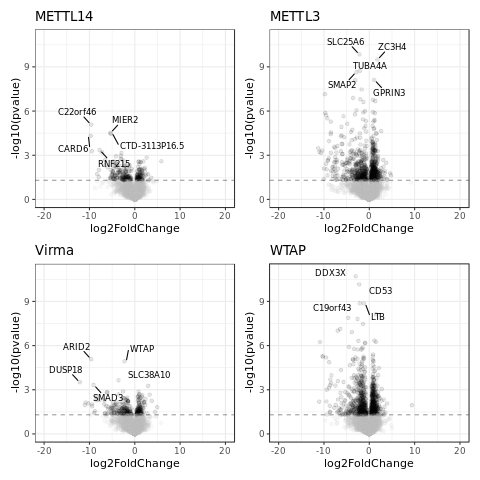

In [22]:
%%R
for (treat in c('METTL14','METTL3','Virma','WTAP')){
    res = all_res[[treat]]
    # significant thr 
    pvalue_lim = 0.05 #; log2FoldChange_lim = 5
    res$sig <- as.factor(
        res$pvalue < pvalue_lim
#         | (abs(res$log2FoldChange) > log2FoldChange_lim & res$pvalue < pvalue_lim)
    )
    relevel(res$sig, ref=TRUE)
#     ## Volcano plot
    vol[[treat]] = res %>% ggplot(aes(x=log2FoldChange, y=-log10(pvalue),colour=sig, fill=sig)) +
            geom_point(aes(color = sig),alpha = 1/10) +
            ggtitle(treat) +
            xlim(c(-20,20)) +
            ylim(c(0,11)) +
            geom_hline(yintercept=-log10(pvalue_lim), linetype="dashed", alpha = 4/10) +
#             geom_vline(xintercept=log2FoldChange_lim, linetype="dashed", alpha = 4/10) +
#             geom_vline(xintercept=(-1)*log2FoldChange_lim, linetype="dashed", alpha = 4/10) +
            scale_color_manual(values = c("grey", "black")) +
            theme_bw() + theme(legend.position="none") +
            geom_text_repel(
                data = subset(res[order(res$pvalue),], sig == TRUE)[1:5,],
                aes(label = name),
                size = 3,
                box.padding = unit(0.35, "lines"),
                point.padding = unit(0.3, "lines")
            )
}
v = vol$METTL14 + vol$METTL3 + vol$Virma + vol$WTAP
ggsave("plots/peak_Volcanos.png", plot = v, device = 'png', dpi = 300)
ggsave("plots/peak_Volcanos.pdf", plot = v, device = 'pdf', dpi = 300)
v

[Wilcoxon signed rank test](http://www.sthda.com/english/wiki/one-sample-wilcoxon-signed-rank-test-in-r) and t-test

[1] "METTL14"

	Wilcoxon signed rank test with continuity correction

data:  res$log2FoldChange
V = 13403000, p-value = 2.626e-05
alternative hypothesis: true location is less than 0


	One Sample t-test

data:  res$log2FoldChange
t = -12.41, df = 7526, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.1661212 -0.1208004
sample estimates:
 mean of x 
-0.1434608 

[1] "METTL3"

	Wilcoxon signed rank test with continuity correction

data:  res$log2FoldChange
V = 12628000, p-value < 2.2e-16
alternative hypothesis: true location is less than 0


	One Sample t-test

data:  res$log2FoldChange
t = -16.202, df = 7525, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.2949141 -0.2312522
sample estimates:
 mean of x 
-0.2630832 

[1] "Virma"

	Wilcoxon signed rank test with continuity correction

data:  res$log2FoldChange
V = 13353000, p-value = 8.105e-06
alternative hypothesis: true l

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



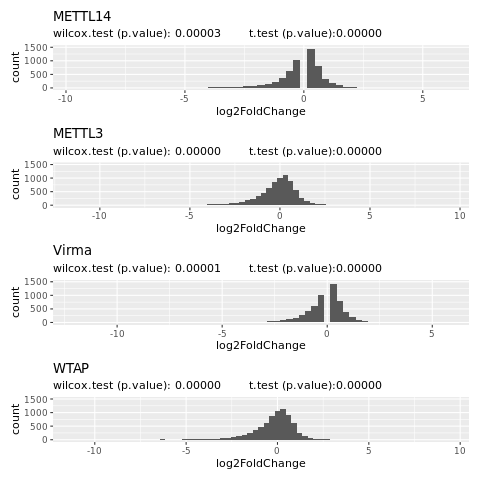

In [17]:
%%R
for (treat in c('METTL14','METTL3','Virma','WTAP')){
    res <- all_res[[treat]]
    d <- res$log2FoldChange[!is.na(res$log2FoldChange)]
    w <- wilcox.test(res$log2FoldChange,mu = 0, alternative = "less")
    
    t <- t.test(res$log2FoldChange, mu=0)

    print (treat)
    print (w)
    print (t)
    
    hist[[treat]] = ggplot(res, aes(x=log2FoldChange)) +
            ggtitle(
                treat, 
                sprintf("wilcox.test (p.value): %.5f \t t.test (p.value):%.5f", w$p.value, t$p.value)
            ) +
            ylim(c(-10,1500)) +
            geom_histogram(binwidth=0.3)
}
h = hist$METTL14 / hist$METTL3 / hist$Virma / hist$WTAP
ggsave("plots/peak_Histograms.png", plot = h, device = 'png', dpi = 300)
ggsave("plots/peak_Histograms.pdf", plot = h, device = 'pdf', dpi = 300)
h

## Pairwise correlation of each treatments 
http://www.sthda.com/english/wiki/correlation-matrix-a-quick-start-guide-to-analyze-format-and-visualize-a-correlation-matrix-using-r-software

In [16]:
%%R
library(Hmisc)
library(corrplot)
library(pheatmap)

In [12]:
%%R
all_fc = data.frame(
    METTL14 = all_res$METTL14$log2FoldChange,
    METTL3 = all_res$METTL3$log2FoldChange,
    Virma = all_res$Virma$log2FoldChange,
    WTAP = all_res$WTAP$log2FoldChange,
    row.names = rownames(all_res[[1]])
)
colSums(is.na(all_fc))

METTL14  METTL3   Virma    WTAP 
      2       3       2       2 


In [13]:
%%R
res2 <- rcorr(as.matrix(all_fc))
# # Extract the correlation coefficients
# res2$r
# # Extract p-values
# res2$P

pdf("plots/Corrplot.pdf", width=7, height=7)
c = corrplot(res2$r, type="upper", order="hclust", method="pie",
         p.mat = res2$P, sig.level = 0.01, insig = "blank")
dev.off()
png("plots/Corrplot.png")
c = corrplot(res2$r, type="upper", order="hclust", method="pie",
         p.mat = res2$P, sig.level = 0.01, insig = "blank")
dev.off()

png 
  2 


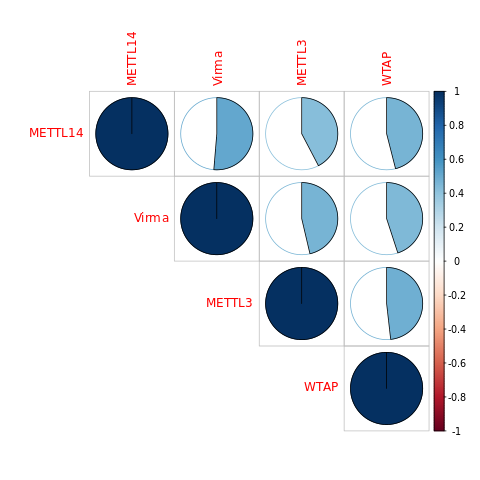

In [14]:
%%R
corrplot(
    res2$r, type="upper", 
    order="hclust", method="pie",
    p.mat = res2$P, sig.level = 0.01, insig = "blank")

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



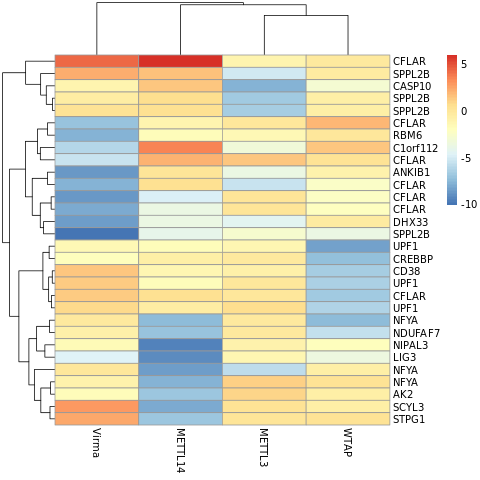

In [15]:
%%R
# mostVar Calculate the top n most variable genes in a matrix of gene expression data
# https://rdrr.io/github/abc-igmm/transcripTools/man/mostVar.html
mostVar <- function(data, n, i_want_most_var = TRUE) {
  data.var <- apply(data, 1, stats::var)
  data[order(data.var, decreasing = i_want_most_var)[1:n],] 
}
# scale - Z-Score
fc <- data.frame(apply(all_fc,2,scale, center=TRUE, scale=TRUE), row.names=rownames(all_fc))

# idtransfer
peak_ids = strsplit(rownames(all_fc), '_',)
ids = unlist(lapply(peak_ids, '[[', 1))

# filter most variable genes
fc = mostVar(fc,30)
# Plot heatmap
h1 <- pheatmap(fc, labels_row = gtf_df[ids,])
        ggsave('plots/peak_mostVar_Heatmap.png', plot = h1, device = 'png', dpi = 300)
ggsave('plots/peak_mostVar_Heatmap.pdf', plot = h1, device = 'pdf', dpi = 300)
h1

## iPAGE
Enrichment analysis 

In [78]:
%%bash --err error
mkdir -p ipage
declare -a StringArray=('METTL14' 'METTL3' 'Virma' 'WTAP')
for treat in "${StringArray[@]}"; do
    # remove peak number 
    awk 'NR>1{split($1,id,"."); print id[1]"\t"$3}' deseq/d_mtyl_${treat}_vs_NT.txt > deseq/d_mtyl_${treat}_vs_NT.c.txt
    for f in `ls -d /flash/bin/iPAGEv1.0/PAGE_DATA/ANNOTATIONS/human_ensembl*`; do
        base=`basename "$f"`
        perl $PAGEDIR/page.pl --expfile=deseq/d_mtyl_${treat}_vs_NT.c.txt \
        --species=$base --exptype=continuous --ebins=11 --nodups=1
        mv -v deseq/d_mtyl_${treat}_vs_NT.c.txt_PAGE/ ipage/d_mtyl_${treat}_vs_NT_${base}/
    done
done

Reading expression data ... 1 by 7528... Done.
Creating hash ... Done
Reading GO names table ... entering
Done.
Reading GO index table ... entering
Done.
go_terms_num: 17689
Creating hash table for gene names in gene ontology index file ... Done.
gene num = 7509 out of 7528 
Creating hash table for gene ontology names ... Done.
Populating the GO profile table ... 7509	17689
Done.
Writing internal quantized groups ...Done
683 hits go_terms_num = 17689
cat 658, mi = 0.00299231, Notch signaling pathway
cat 2542, mi = 0.00298120, negative regulation of proteasomal ubiquitin-dependent protein catabolic process
cat 725, mi = 0.00292438, transcriptional repressor activity, RNA polymerase II transcription factor binding
cat 1968, mi = 0.00290173, secretory granule membrane
cat 869, mi = 0.00286084, regulation of cell adhesion
cat 1329, mi = 0.00282004, regulation of inflammatory response
cat 3519, mi = 0.00280437, SH3/SH2 adaptor activity
cat 84, mi = 0.00275510, animal organ regeneration
cat 

In [86]:
%%bash 
declare -a StringArray=('METTL14' 'METTL3' 'Virma' 'WTAP')
for treat in "${StringArray[@]}"; do
    for f in `ls -d /flash/bin/iPAGEv1.0/PAGE_DATA/ANNOTATIONS/human_ensembl*`; do
        base=`basename "$f"`        
        magick -density 300 \
        ipage/d_mtyl_${treat}_vs_NT_${base}/d_mtyl_${treat}_vs_NT.c.txt.summary.pdf \
        -flatten -quality 90 plots/ipage.d_mtyl_${treat}_vs_NT_${base}.png
        echo '<table>'
        echo '  <tr>'
        echo '    <td><img src=plots/ipage.d_mtyl_'${treat}_vs_NT_${base}'.png style="width:600px">'
        echo -e "\\t"$base
        echo '  <tr>'
        echo '<table>'
    done
done


# Hypo and Hyper-methylation gene set analysis: 

Let's try Salmon for the alignment and experssion quntification; We are doing this because `STAR` + `featurecount` didn't quntify most of the transcripts in the input samples. 

In [ ]:
salmon index -t ~/genomes/hg38/gencode.v28.transcripts.fa \
-i ~/genomes/hg38/gencode.v28.transcripts.salmon_index

In [46]:
%%bash
# I needed seprate conda env for this purpose 
mkdir -p quants
mkdir -p _sh/_log/salmon
# -l A or -l SR ?!
declare -a StringArray=('METTL14' 'METTL3' 'Virma' 'WTAP' 'NT')
for treat in "${StringArray[@]}"; do 
    for f in fastq/*_IN_2[3-4]_$treat*trim*; do 
        base=`basename "$f"`;
        out=${base/*_IN_/s};
        out=${out/_S*/.input};
        out=${out/_/.};        
        echo 'nohup salmon quant -i ~/genomes/hg38/gencode.v28.transcripts.salmon_index/ -l A -r '$f' -p 12 --validateMappings -o quants/'$out' > _sh/_log/salmon/'$out'.salmon.out&'
    done;
done

nohup salmon quant -i ~/genomes/hg38/gencode.v28.transcripts.salmon_index/ -l A -r fastq/03_IN_23_METTL14_S5_L002_trim.fastq.gz -p 8 --validateMappings -o quants/s23.METTL14.input > _sh/_log/salmon/s23.METTL14.input.salmon.out&
nohup salmon quant -i ~/genomes/hg38/gencode.v28.transcripts.salmon_index/ -l A -r fastq/08_IN_24_METTL14_S10_L002_trim.fastq.gz -p 8 --validateMappings -o quants/s24.METTL14.input > _sh/_log/salmon/s24.METTL14.input.salmon.out&
nohup salmon quant -i ~/genomes/hg38/gencode.v28.transcripts.salmon_index/ -l A -r fastq/02_IN_23_METTL3_S4_L002_trim.fastq.gz -p 8 --validateMappings -o quants/s23.METTL3.input > _sh/_log/salmon/s23.METTL3.input.salmon.out&
nohup salmon quant -i ~/genomes/hg38/gencode.v28.transcripts.salmon_index/ -l A -r fastq/07_IN_24_METTL3_S9_L002_trim.fastq.gz -p 8 --validateMappings -o quants/s24.METTL3.input > _sh/_log/salmon/s24.METTL3.input.salmon.out&
nohup salmon quant -i ~/genomes/hg38/gencode.v28.transcripts.salmon_index/ -l A -r fastq/04_I

In [8]:
%reload_ext rpy2.ipython

In [14]:
%%R 
library(DESeq2)
library(tidyverse)
library(ggplot2)
library(tximport)
library(readr)

In [ ]:
# https://rdrr.io/github/jmw86069/splicejam/man/makeTx2geneFromGtf.html

In [25]:
%%R 
files <- list.files(pattern="quant.sf",full.names = TRUE, recursive=T)
tx2gene <- read_tsv("/rumi/shams/genomes/hg38/gencode.v28.basic.tx2gene.cvs")

R[write to console]: Parsed with column specification:
cols(
  TXNAME = col_character(),
  GENEID = col_character()
)



In [27]:
%%R 
head (tx2gene)

# A tibble: 6 x 2
  TXNAME            GENEID           
  <chr>             <chr>            
1 ENST00000456328.2 ENSG00000223972.5
2 ENST00000450305.2 ENSG00000223972.5
3 ENST00000473358.1 ENSG00000243485.5
4 ENST00000469289.1 ENSG00000243485.5
5 ENST00000607096.1 ENSG00000284332.1
6 ENST00000606857.1 ENSG00000268020.3


In [38]:
%%R 
names(files) <- gsub("./(\\S+)_quant/quant.sf","\\1",files)
txi <- tximport(files, type = "salmon", tx2gene = tx2gene, txOut=T)

R[write to console]: reading in files with read_tsv

R[write to console]: 1 
R[write to console]: 2 
R[write to console]: 3 
R[write to console]: 4 
R[write to console]: 5 
R[write to console]: 6 
R[write to console]: 7 
R[write to console]: 8 
R[write to console]: 9 
R[write to console]: 10 
R[write to console]: 



In [39]:
%%R 
txi.gene <- summarizeToGene(txi, tx2gene, ignoreAfterBar= TRUE)

R[write to console]: transcripts missing from tx2gene: 102647

R[write to console]: summarizing abundance

R[write to console]: summarizing counts

R[write to console]: summarizing length



In [206]:
%%R 
lfc.cutoff = 1
# meta 
reps <- c(rep('s23',5),rep('s24',5))
treats <- rep(c('METTL14','METTL3','NT','Virma','WTAP'),2)

colData <- data.frame(cond=treats, rep=reps, row.names=colnames(txi$abundance))

dds <- DESeqDataSetFromTximport(txi.gene, colData = colData, design = ~cond + rep)
dds$cond<- relevel(dds$cond, ref="NT")
dds <- DESeq(dds)

all_res <- list()
for (t in c('METTL14','METTL3','Virma','WTAP')){
    all_res[[t]]<- results(dds, contrast=c('cond',t,'NT'))
}

R[write to console]: using counts and average transcript lengths from tximport

R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



In [207]:
%%R 
for (t in c('METTL14','METTL3','Virma','WTAP')){
    res = all_res[[t]]
    res = data.frame(res [!is.na(res$padj) ,c(2,6)])
    write.table(res, paste("teiser/",t,"_vs_NT_lfc.txt", sep = ''), sep="\t", quote=FALSE, col.names=NA )
}

## TEISER
https://github.com/goodarzilab/TEISER


prepare inputs 

In [212]:
%%bash
mkdir -p teiser
declare -a StringArray=('METTL14' 'METTL3' 'Virma' 'WTAP')
for treat in "${StringArray[@]}"; do
    ### exp input 
    # remove dups 
    awk -F "\t" '{OFS=FS}NR>1{$1=substr($1,1,15); print $1, $2}' teiser/${treat}_vs_NT_lfc.txt | awk '!seen[$1]++' > teiser/${treat}_vs_NT_lfc.c.txt
    ### hyper_methylation gene list
    # subset by threshold
    awk '$2>=2{print $1}' deseq/d_mtyl_${treat}_vs_NT.c.txt | awk '!seen[$1]++' > teiser/${treat}_hyper_methylation.txt
    # intersect with exp
    awk 'NR==FNR{A[$1];next}$1 in A' teiser/${treat}_vs_NT_lfc.c.txt teiser/${treat}_hyper_methylation.txt > teiser/${treat}_hyper_methylation.c.txt
    ### hypo_methylation gene list
    # subset by threshold
    awk '$2<-2 {print $1}' deseq/d_mtyl_${treat}_vs_NT.c.txt | awk '!seen[$1]++' > teiser/${treat}_hypo_methylation.txt
    # intersect with exp
    awk 'NR==FNR{A[$1];next}$1 in A' teiser/${treat}_vs_NT_lfc.c.txt teiser/${treat}_hypo_methylation.txt > teiser/${treat}_hypo_methylation.c.txt
done 

In [213]:
%%bash
declare -a StringArray=('METTL14' 'METTL3' 'Virma' 'WTAP')
for treat in "${StringArray[@]}"; do
    echo hyper_methylation
    perl $TEISERDIR/run_mi_gene_list.pl \
    --expfile=teiser/${treat}_vs_NT_lfc.c.txt \
    --genefile=teiser/${treat}_hyper_methylation.c.txt \
    --exptype=continuous \
    --ebins=7 \
    --species=human \
    --doremovedups=0 \
    --doremoveextra=0
    mv -v teiser/${treat}_vs_NT_lfc.c.txt_GENESET teiser/${treat}_hyper_methylation_GENESET
    
    magick -density 300 \
    teiser/${treat}_hyper_methylation_GENESET/*pdf \
    -flatten -quality 90 plots/teiser.${treat}_hyper_methylation_GENESET.png
    
    echo hypo_methylation
    perl $TEISERDIR/run_mi_gene_list.pl \
    --expfile=teiser/${treat}_vs_NT_lfc.c.txt \
    --genefile=teiser/${treat}_hypo_methylation.c.txt \
    --exptype=continuous \
    --ebins=7 \
    --species=human \
    --doremovedups=0 \
    --doremoveextra=0
    mv -v teiser/${treat}_vs_NT_lfc.c.txt_GENESET teiser/${treat}_hypo_methylation_GENESET
    
    magick -density 300 \
    teiser/${treat}_hypo_methylation_GENESET/*pdf \
    -flatten -quality 90 plots/teiser.${treat}_hypo_methylation_GENESET.png
done

hyper_methylation
The TEISERDIR environment variable is /flash/bin/TEISERv1.1
Sat May  2 01:49:52 UTC 2020
Remove duplicates, create teiser/METTL14_vs_NT_lfc.c.txt_GENESET/METTL14_vs_NT_lfc.c.txt
Quantizing the input file.
step 2: seed optimization.
Expfile loaded: 17979 values...
Adding small values...
Quantizing the input vector...Done
Number of clusters: 7
calculating the p-value matrix.
Allocating memory ... Done
doing stats: mi = 0.000255
pass = 0.404800
z = 0.047909
freq 0: 0.001947	5	2568	52	17979
freq 1: 0.004673	12	2568	52	17979
freq 2: 0.003115	8	2568	52	17979
freq 3: 0.003894	10	2568	52	17979
freq 4: 0.002336	6	2568	52	17979
freq 5: 0.001558	4	2568	52	17979
freq 6: 0.002723	7	2571	52	17979
step 7: drawing matrix.
Reading MI data ... Done.
Start drawing
0.84	-1.36
0
Outputing EPS file teiser/METTL14_vs_NT_lfc.c.txt_GENESET/METTL14_vs_NT_lfc.c.txt.summary.eps
Convert to PDF teiser/METTL14_vs_NT_lfc.c.txt_GENESET/METTL14_vs_NT_lfc.c.txt.summary.pdf
ps2pdf -dEPSCrop -dAutoRotate

Option suffix requires an argument
Option suffix requires an argument
Option suffix requires an argument
Option suffix requires an argument
Option suffix requires an argument
Option suffix requires an argument
Option suffix requires an argument
Option suffix requires an argument


<!-- ### using bam to bed for cov count 

1. `intersectBed -split` make it work with bed12 file

3. make a intersect gtf to extract names for later. ` --> 

In [108]:
# %%bash 
# bamToBed -i bam/s23.human.METTL3.input.bam | intersectBed -s -split -wo -a - -b exomepeak/control/peak.bed | awk '{print $10}' | sort  tail

In [109]:
# %%bash 
# bamToBed -i bam/s23.human.METTL3.input.bam | intersectBed -s -split -wo -a - -b exomepeak/control/peak.bed \
# | cut -f10 | sort | uniq -c | awk '{ print $2 "\t" $1}' | head

In [113]:
%%R 
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.2 LTS

Matrix products: default
BLAS/LAPACK: /rumi/shams/abe/anaconda3/envs/deseq/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] parallel  stats4    tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] tximport_1.10.1             forcats_0.4.0              
 [3] stringr_1.4.0               dplyr_0.8.3                
 [5] purrr_0.3.3                 readr_1.3.1                
 [7] tidyr_1.0.0                 tibble_2.1.3               
 [9] ggplot2_3.2.1    